# Sunspots prediction in time series with Keras LSTM model: batch_size effect 
       
<img src="https://www.weather.gov/images/fsd/astro/Sun_sunspot.jpg" alt="Sunspots" title="Sunspots" />

                                               picture from [weather.gov]
                                               (https://www.weather.gov/images/fsd/astro/Sun_sunspot.jpg)

* In the Laurence Moroney's "Sequences, Time Series and Predictions" class (https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction), week 4 project is to use LSTM to predict sunspots activities. He suggest us to play with the batch size parameters to lower the ripple in the accuracy vs epoch, and find the best predictions (lowest MAE).  
### Summary<br>
Initially, I expected larger batch_size will lead to better training loss/mae, less ripple in the loss/mae vs epochs curve and better validation results. In the end, I got better training loss/mae, not noticable decrease in ripple. The validation mae results become worse, which may due to limited validation data. 

1).[EDA and data loading](#eda) 

2).[Model setup](#setup)

3).[Loss, Accuracy results, and batch_size analysis](#results)

4) [Data setup with numpy method](#numpy)


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time (month)")
    plt.ylabel("Value")
    plt.grid(True)

<a id="eda"> </a>
## EDA and data loading 

In [8]:
#data=pd.read_csv('/kaggle/input/sunspots/Sunspots.csv')
data=pd.read_csv('Sunspots.csv')
data.head()

Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7

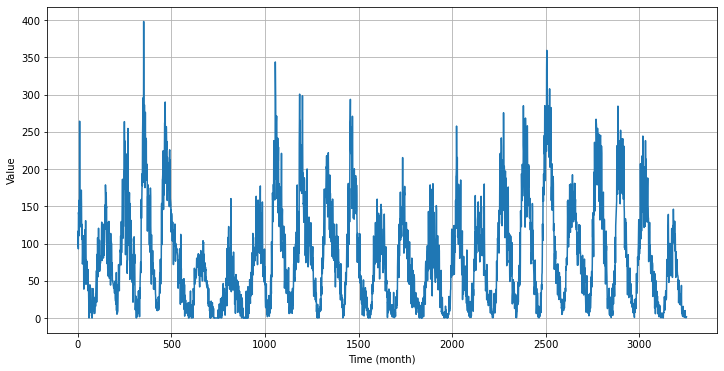

In [9]:
series=data.iloc[:,2].to_numpy()
time=data.iloc[:,0].to_numpy()
plt.figure(figsize=(12,6))
plot_series(time, series)

<a id="setup"></a>
## Model setup

Use Stacked LSTM for more complexity and better performance.

One trick to save time in the stacked LSTM<br>
make sure turn the second LSTM return_sequences=False:<br>
***model=...<br>
  tf.keras.layers.LSTM(60, return_sequences=True),<br>
  tf.keras.layers.LSTM(60, return_sequences=False),*
...<br>**

   To match this setup, making sure the window setup with only one output (window[-1]): <br>
***def windowed_dataset(<br>
   ds = ds.map(lambda window: (window[:-1], window[-1]))***
   
   the best learning rate is ~8e-6. (Please check some other kagglers' notebook, which use the similar methods. for example:Kutay's notebook<br>
   https://www.kaggle.com/kutaykutlu/time-series-tensorflow-rnn-lstm-introduction)

In [10]:
split_time=2800
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

window_size=30
batch_size=32
shuffle_buffer_size=1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series=tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()
initial_weights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-9 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-9, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
87/87 [==============================] - 9s 35ms/step - loss: 5959.9893

(1e-09, 0.001, 0.0, 10000.0)

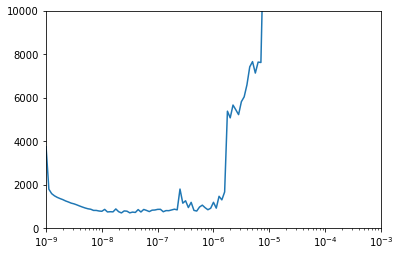

In [14]:
lrs = 1e-9 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-9, 1e-3, 0, 10000])    

In [15]:
import time as tm

In [16]:
model.set_weights(initial_weights)
start_time=tm.time()
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_batch32 = model.fit(train_set,epochs=200, verbose=1)
end_time=tm.time()
duration=start_time-end_time
print(f'the traning time is: {duration}')

Epoch 1/200
87/87 [==============================] - 10s 44ms/step - loss: 42.9160 - mae: 43.4139

<a id="results"></a>
# Loss (huber), Accuracy, MAE vs Batch_size (32 vs 64)

1. For batch_size=32, the loss and accuracy training results look good, the loss/mae curve vs epochs has a lot of ripple. 
I increase the batch_size, and expected to get better testing results and less ripple in the training loss/accuracy curve.But...
2. For batch_size=64, the loss and accuracy training results look better, but the MAE for the testing results are even worse. The ripple looks similar, not better, comparing to batch_size=32 (estimation by eye in different scales). 
  

In [22]:
def model_forecast(model, series, window_size):
 #   series=tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [23]:
start_time=tm.time()
rnn_forecast = model_forecast(model, series[...,np.newaxis], window_size)
rnn_forecast_val = rnn_forecast[split_time - window_size:-1, 0]
end_time=tm.time()
duration=end_time-start_time
print(f'the forecast time is: {duration}')

the forecast time is: 2.528430700302124


In [24]:
rnn_forecast.shape

(3223, 1)

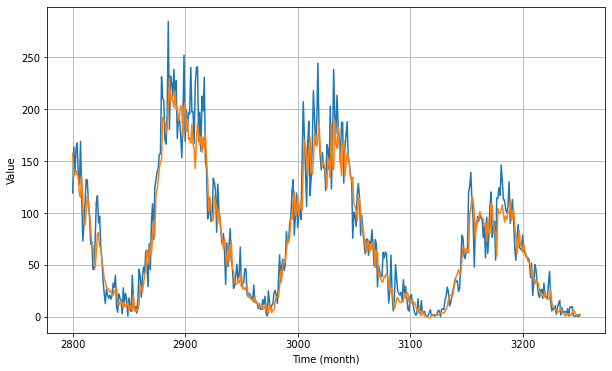

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast_val)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast_val).numpy()

14.991227

In [27]:
import seaborn as sns
def plot_accuracy(history):
    mae=history.history['mae']
    loss=history.history['loss']
    epochs=range(len(loss))
    
    fig = plt.figure(figsize=(12,6))
    fig.add_subplot(1,2,1)
    sns.lineplot(epochs, mae)
    sns.lineplot(epochs, loss)
    plt.title('MAE and Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["MAE", "Loss"])
    
    epochs_zoom = epochs[100:]
    mae_zoom = mae[100:]
    loss_zoom = loss[100:]

    fig.add_subplot(1,2,2)
    sns.lineplot(epochs_zoom, mae_zoom)
    sns.lineplot(epochs_zoom, loss_zoom)
    plt.title('MAE and Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["MAE", "Loss"])

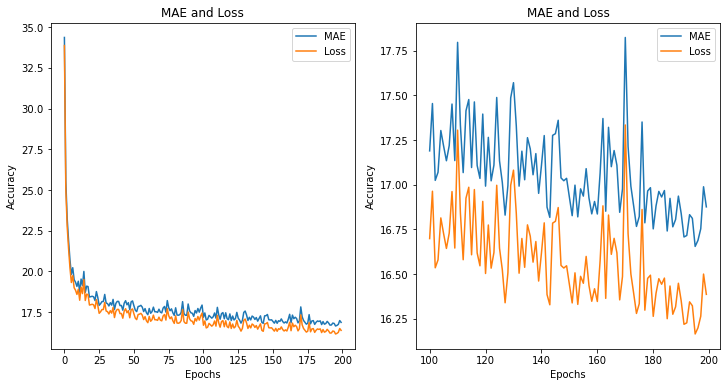

In [28]:
plot_accuracy(history_batch32)

## For batch_size=64, repeat the model train and prediction

In [29]:
batch_size=64

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])




In [31]:
model.set_weights(initial_weights)
start_time=tm.time()
history_batch64 = model.fit(train_set,epochs=200, verbose=1)
end_time=tm.time()
duration=start_time-end_time
print(f'the traning time with batch 64 is: {duration}')

Epoch 1/200
44/44 [==============================] - 3s 62ms/step - loss: 41.7528 - mae: 42.2498

In [32]:
start_time=tm.time()
rnn_forecast_b64 = model_forecast(model, series[...,np.newaxis], window_size)
rnn_forecast_short_b64 = rnn_forecast_b64[split_time - window_size:-1, 0]
end_time=tm.time()
duration=end_time-start_time
print(f'the forecast time with batch 64is: {duration}')

the forecast time with batch 64is: 2.22861647605896


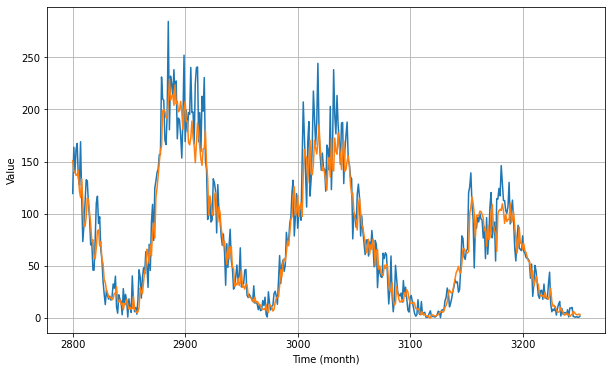

In [33]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast_short_b64)

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast_short_b64).numpy()

14.87796

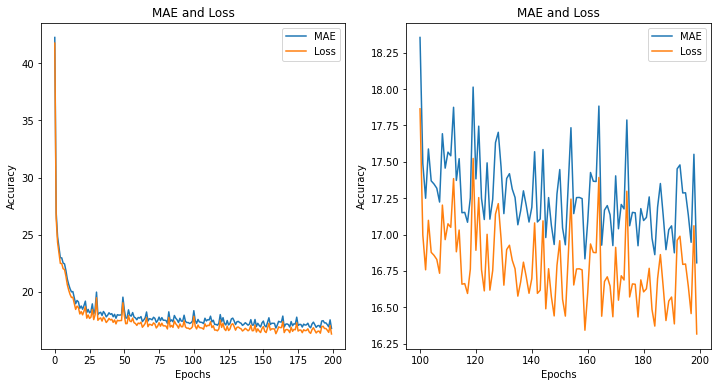

In [35]:
plot_accuracy(history_batch64)

<a id="numpy"> </a>
## Data setup with numpy method

In [36]:
def window_dataset_np(series, window_size, batch_size):
    x_train, y_train=[],[]
    for i in range(0,series.shape[0]-window_size):
        x_train.append(series[i:i+window_size])
        y_train.append(series[i+window_size])
    x_train=np.array(x_train)
    x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    #np.random.shuffle(x_train) #shuffle the x_train, but not insync with y_train
    y_train=np.array(y_train)
    return x_train, y_train

In [37]:
batch_size=32
x_train_np, y_train_np=window_dataset_np(x_train, window_size, batch_size)


In [38]:
from sklearn.utils import shuffle
x_train_np, y_train_np = shuffle(x_train_np, y_train_np, random_state=0)

In [39]:
model.set_weights(initial_weights)
start_time=tm.time()
history_np = model.fit(x_train_np, y_train_np,epochs=200, verbose=1, batch_size=batch_size)#, shuffle=True)
end_time=tm.time()
duration=end_time-start_time
print(f'the traning time with numpy dataset is: {duration}')

Epoch 1/200
87/87 [==============================] - 8s 39ms/step - loss: 33.8535 - mae: 34.3499

In [40]:
start_time=tm.time()

forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size, np.newaxis][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

end_time=tm.time()
duration=end_time-start_time
print(f'the forecast time with numpy setup is: {duration}')

the forecast time with numpy setup is: 187.72168827056885


### The numpy method for training process took about the same time, but forecast process took much longer time to calculate than the dataset method.

In [41]:
results_2=np.array(forecast)
print(results_2.shape, results.shape)

(452, 1, 1) (452,)


###The forecast results are 3-dimensions, which need to be cut to 1 dimension

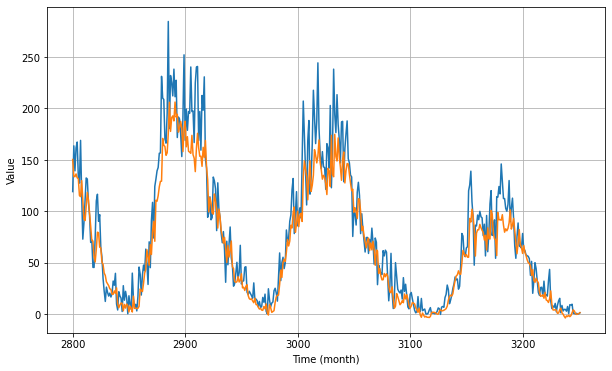

In [42]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
#plot_series(time_valid, results_2)
plot_series(time_valid, results)

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

17.154034

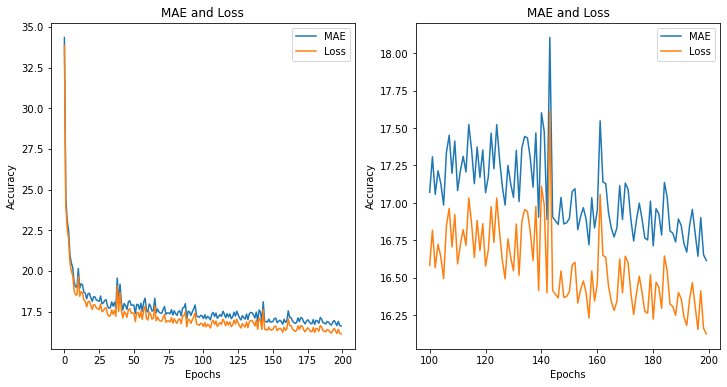

In [44]:
plot_accuracy(history_np)